# Example of using TR_ADE model

## 1. Setup

In [1]:
import tensorflow as tf
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
# import os, random, numpy as np
# SEED = 1000
# os.environ["PYTHONHASHSEED"] = str(SEED)
# os.environ["TF_DETERMINISTIC_OPS"] = "1"
# os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
# random.seed(SEED)
# np.random.seed(SEED)

# import tensorflow as tf
# tf.keras.utils.set_random_seed(SEED)
# tf.config.threading.set_intra_op_parallelism_threads(1)
# tf.config.threading.set_inter_op_parallelism_threads(1)


### 1.1 Install requirements

In [2]:
# %pip install --upgrade pymc3
# %pip install numpy==1.23.5
# %pip install scipy==1.14.1
# %pip install tensorflow==2.17.0 keras==3.5.0
# %pip install kagglehub
# %pip install scikit-learn==1.5.2
# %pip install seaborn==0.13.2

In [3]:
from TR_ADE import *
from TR_ADE_pipeline import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sc
from model_args import getArgs 

from sklearn.model_selection import train_test_split

import kagglehub
from kagglehub import KaggleDatasetAdapter

seed = 1000
set_seed(seed)

In [4]:
args = getArgs([])
args

Namespace(seed=1000, batch_size=100, epochs=5000, latent_dim=3, num_clusters=15, gamma=1, classify=True, num_output_head=3, num_classes=2, validation_frac=0.2, imputation_strategy='MICE', scaling_strategy='standard', iqr_scaler=1.5, data_path='./data', results_path='./results', pip_reqs_path='requirements.txt', use_early_stopping=True, early_stopping_patience=50, learning_rate=0.001, use_lr_schedule=True, s_to_classifier=False, learn_prior=True, final_activation='softmax', c_sigma_initializer='glorot', nn_layers=[64, 32, 16])

In [5]:
data_path = args.data_path

# heartdata = pd.read_csv(data_path + '/heart_attack_risk_dataset.csv')
# heartdata = pd.read_csv(data_path + '/wine-clustering.csv')
heartdata = pd.read_csv(data_path + '/heart.csv')
heartdata.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
gender = {'M': 0, 'F': 1}
angina = {'N': 0, 'Y': 1}

heartdata.Sex = [gender[i] for i in heartdata.Sex]
heartdata.ExerciseAngina = [angina[i] for i in heartdata.ExerciseAngina ]

In [7]:
heartdata.head()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,0,ATA,140,289,0,Normal,172,0,0.0,Up,0
1,49,1,NAP,160,180,0,Normal,156,0,1.0,Flat,1
2,37,0,ATA,130,283,0,ST,98,0,0.0,Up,0
3,48,1,ASY,138,214,0,Normal,108,1,1.5,Flat,1
4,54,0,NAP,150,195,0,Normal,122,0,0.0,Up,0


In [8]:
# heartdata['Female'] = pd.get_dummies(heartdata['Gender'])['Female']
# heartdata = heartdata.drop(columns = ['Gender'])


In [9]:
# y_data = heartdata['Heart_Attack_Risk']
y_data = heartdata['HeartDisease']
# X_data = heartdata[[col for col in heartdata.columns if col !='Heart_Attack_Risk']]
X_data = heartdata[[col for col in heartdata.columns if col !='HeartDisease']]

In [10]:
X_train, X_test, y_train, y_test  = train_test_split(X_data, y_data.values.reshape(-1,1), stratify=y_data)
# X_train, X_test = train_test_split(heartdata)

In [11]:
y_data.value_counts()

1    508
0    410
Name: HeartDisease, dtype: int64

In [12]:
args.num_output_head=1
args.num_classes = len(np.unique(y_train))
args.latent_dim = 3
args.num_clusters = 5
args.learn_prior = True
args.classify = True
args.nn_layers = [40, None, None]
args.c_sigma_initializer = 'constant'
args.s_to_classifier = False

In [13]:
preprocessor = PREPROCESSOR_WRAPPER(args)
preprocessor.build(X_train, X_test)
train_generator, val_generator, train_data, val_data = preprocessor.data_pipeline(X_train, y_train, return_generator=True)
# train_generator, val_generator, train_data, val_data = preprocessor.data_pipeline(X_train, None, return_generator=True)

ChestPainType seems to be categorical and will be removed. Please onehot encode or add categorical likelihood handling.
RestingECG seems to be categorical and will be removed. Please onehot encode or add categorical likelihood handling.
ST_Slope seems to be categorical and will be removed. Please onehot encode or add categorical likelihood handling.


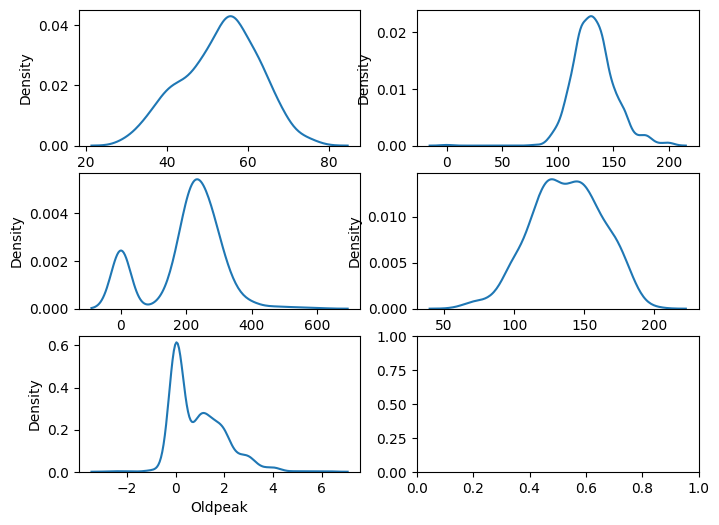

In [14]:
fig, axes = plt.subplots(3, 2, figsize=(8,6))
axes = axes.flatten()
for ax, feat in zip(axes, preprocessor.cont_features):
    sns.kdeplot(ax=ax, data=X_train, x=feat)
    
plt.show()

In [15]:
tr_ade = TR_ADE_WRAPPER(args, preprocessor.cont_dim, preprocessor.bin_dim)
tr_ade.build()

In [16]:
tr_ade.TR_ADE.c_mu

<tf.Variable 'c_mu:0' shape=(5, 3) dtype=float32, numpy=
array([[ 0.09695123,  0.99391663, -0.69713426],
       [-0.08442955, -0.00619471,  0.19244902],
       [-1.0787301 , -0.49154404,  0.38391382],
       [ 0.32320204,  0.31531647, -0.6510501 ],
       [-0.02407185, -0.15195961, -0.58493066]], dtype=float32)>

In [17]:
tr_ade = TR_ADE_WRAPPER(args, preprocessor.cont_dim, preprocessor.bin_dim)
tr_ade.build()
history = tr_ade.model_fit(train_generator, val_generator)

Epoch 1: classif_loss=0.7099, gmm_loss=0.4889, negloglik_bin=2.0308, negloglik_cont=5.1428, recon_loss=7.1735, total_loss=8.3723, val_classif_loss=0.7393, val_gmm_loss=0.4102, val_negloglik_bin=1.9803, val_negloglik_cont=4.9302, val_recon_loss=6.9105, val_total_loss=8.0600, learning_rate=0.0010
Epoch 50: classif_loss=0.5966, gmm_loss=0.4835, negloglik_bin=1.5573, negloglik_cont=2.4537, recon_loss=4.0110, total_loss=5.0910, val_classif_loss=0.5771, val_gmm_loss=0.3637, val_negloglik_bin=1.5912, val_negloglik_cont=2.3590, val_recon_loss=3.9502, val_total_loss=4.8911, learning_rate=0.0010
Epoch 100: classif_loss=0.5775, gmm_loss=0.5155, negloglik_bin=1.4273, negloglik_cont=2.2195, recon_loss=3.6468, total_loss=4.7399, val_classif_loss=0.5682, val_gmm_loss=0.3195, val_negloglik_bin=1.4761, val_negloglik_cont=2.1515, val_recon_loss=3.6276, val_total_loss=4.5152, learning_rate=0.0005
Epoch 150: classif_loss=0.5508, gmm_loss=0.5744, negloglik_bin=1.4081, negloglik_cont=2.1398, recon_loss=3.54

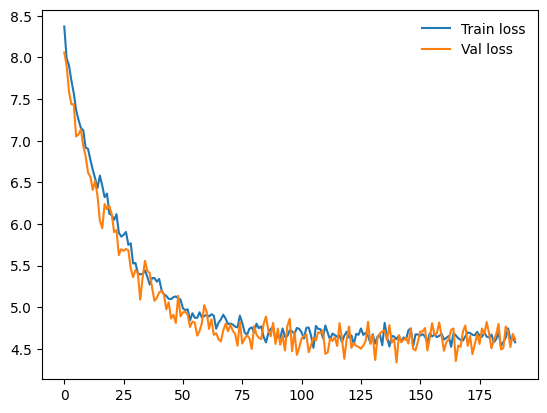

In [18]:
plt.plot(history.epoch, history.history['total_loss'], label='Train loss')
plt.plot(history.epoch, history.history['val_total_loss'], label='Val loss')
plt.legend(frameon=False)
plt.show()

In [19]:
X_all = pd.concat([train_data[0], val_data[0]], axis=0).loc[X_train.index].reset_index(drop=True)
X_all

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex,FastingBS,ExerciseAngina
0,-0.249719,0.046778,-0.535794,0.077949,-0.789029,0,1,0
1,0.067720,-0.725897,-0.285672,0.117101,-0.894475,1,1,0
2,0.067720,1.849688,1.277593,1.487435,-0.894475,0,0,0
3,-0.355533,-0.725897,-1.577971,0.900149,-0.894475,0,0,0
4,0.702600,0.304337,-1.015196,-0.431032,-0.578138,0,0,0
...,...,...,...,...,...,...,...,...
683,0.067720,-0.403949,-0.410733,-0.587642,1.214437,0,0,0
684,1.549106,0.433116,0.174084,-0.274423,2.268893,0,0,1
685,-1.836918,-1.369793,-0.302581,-0.470185,0.159981,0,1,1
686,-1.413665,-0.403949,-0.152764,1.095911,-0.894475,0,1,0


In [20]:
y_tr = train_data[2]
y_tr.index = train_data[0].index
y_vl = val_data[2]
y_vl.index = val_data[0].index

y_all = pd.concat([y_tr, y_vl], axis=0).loc[X_train.index].reset_index(drop=True)


In [21]:
z_mean, z_logvar, z = tr_ade.TR_ADE.encoder(X_all)
clusters = tr_ade.TR_ADE.get_clusters(z_mean)
x_mean_pred, x_logvar_pred, theta_pred = tr_ade.TR_ADE.decoder(z_mean)
reconstructed = tf.concat([x_mean_pred, theta_pred], axis=1)

In [22]:
np.unique(clusters, return_counts=True)


(array([0, 1, 2, 3, 4], dtype=int64),
 array([ 25,   1, 186, 193, 283], dtype=int64))

In [23]:
clust_probs = tr_ade.TR_ADE.get_clusters(z_mean, probs=True)

In [24]:
clust_probs

<tf.Tensor: shape=(688, 5), dtype=float32, numpy=
array([[0.2412059 , 0.19070315, 0.06561951, 0.23336343, 0.26910797],
       [0.27488118, 0.13911594, 0.03495711, 0.17705983, 0.37398604],
       [0.35643324, 0.14305092, 0.01697364, 0.11429176, 0.3692505 ],
       ...,
       [0.09963156, 0.23062155, 0.18071903, 0.38065007, 0.10837778],
       [0.29115477, 0.15664774, 0.0254022 , 0.16517338, 0.3616218 ],
       [0.11985698, 0.21219552, 0.30096012, 0.28017223, 0.08681528]],
      dtype=float32)>

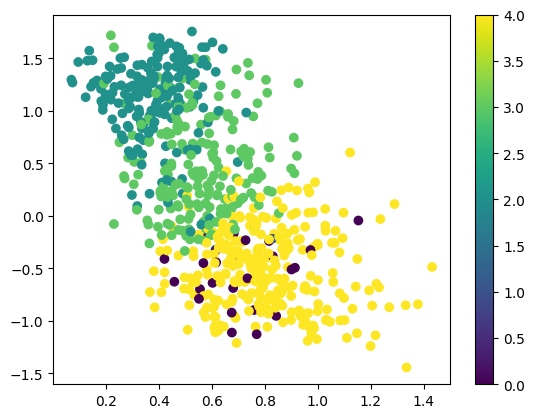

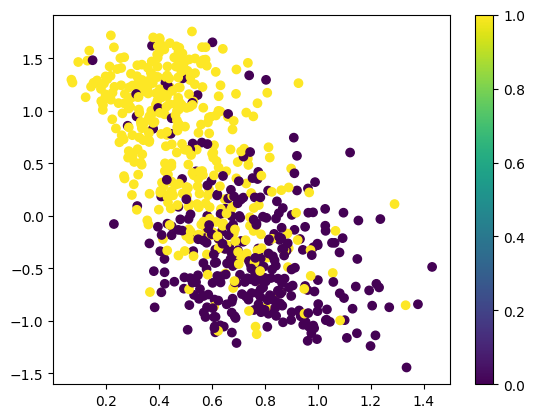

In [25]:
plt.scatter(z_mean[:,0], z_mean[:,1], c=clusters)
plt.colorbar()
plt.show()
plt.scatter(z_mean[:,0], z_mean[:,1], c=y_all.iloc[:,1])
plt.colorbar()
plt.show()

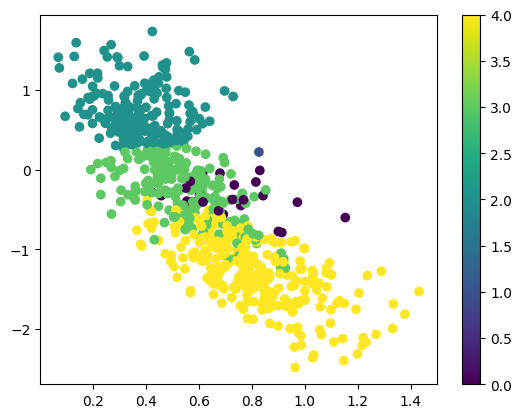

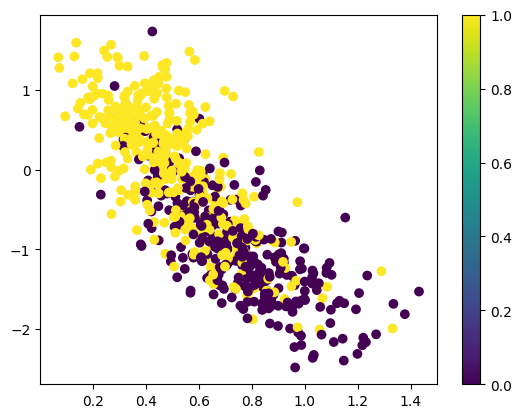

In [26]:
plt.scatter(z_mean[:,0], z_mean[:,2], c=clusters)
plt.colorbar()
plt.show()
plt.scatter(z_mean[:,0], z_mean[:,2], c=y_all.iloc[:,1])
plt.colorbar()
plt.show()

In [28]:

# plt.scatter(z_mean[:,1], z_mean[:,2], c=clusters)
# plt.colorbar()
# plt.show()
# plt.scatter(z_mean[:,1], z_mean[:,2], c=y_all.iloc[:,1])
# plt.colorbar()
# plt.show()
np.linspace(0, 1, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

C:\Users\Elissa\AppData\Local\Temp\ipykernel_18032\114086373.py:8: RuntimeWarning: covariance is not positive-semidefinite.
  cluster_samples = np.random.multivariate_normal(tr_ade.TR_ADE.c_mu[i,:].numpy(), np.diag(tr_ade.TR_ADE.log_c_sigma[i,:]), size = 100)


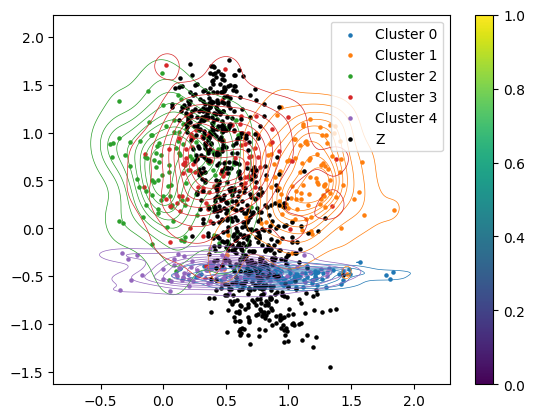

In [ ]:
    
# fig, axes = plt.subplots(ncols=3, figsize=(10,6))
# axes = axes.flatten()
palette = sns.color_palette("tab10", len(np.unique(clusters)))
colors = {cluster: palette[i] for i, cluster in enumerate(np.unique(clusters))}

for i in range(args.num_clusters):
    if i in np.unique(clusters):
        cluster_samples = np.random.multivariate_normal(tr_ade.TR_ADE.c_mu[i,:].numpy(), np.diag(tr_ade.TR_ADE.log_c_sigma[i,:]), size = 100)
        plt.scatter(cluster_samples[:,0],cluster_samples[:,1], label = f'Cluster {i}', s=5, color=colors[i])
        sns.kdeplot(x=cluster_samples[:,0], y=cluster_samples[:,1], linewidths=0.5, color=colors[i])        
plt.scatter(z_mean[:,0], z_mean[:,1], color='black', label='Z', s=5)
plt.scatter(z_mean[:,0], z_mean[:,1], c=clusters, s=3, cmap='cool')
plt.colorbar()
plt.legend()
# plt.ylim(-0.5,0.5)
plt.show()

In [27]:
test_data = preprocessor.preprocess(X_test, y_test)

X_recon, z_mean, clusters, pred_label = tr_ade.model_predict(test_data[0])

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [28]:
test_data[2]

,x0_0,x0_1
0,0.0,1.0
1,0.0,1.0
2,1.0,0.0
3,0.0,1.0
4,0.0,1.0
...,...,...
225,1.0,0.0
226,0.0,1.0
227,0.0,1.0
228,0.0,1.0


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_curve, precision_recall_curve, auc, classification_report
)

def evaluate_classification(probs, true_labels, clusters=None):
    y_true = true_labels.values.ravel()  # Convert DataFrame to numpy array
    y_scores = probs[:, 1]  # Probability of class 1
    y_pred = (y_scores >= 0.5).astype(int)  # Convert to binary predictions

    # Compute overall metrics
    # accuracy = accuracy_score(y_true, y_pred)
    # precision = precision_score(y_true, y_pred)
    # recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Compute Precision-Recall curve and AUC
    precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall_vals, precision_vals)

    # Print overall metrics
    # print(f'\nOverall Accuracy: {accuracy:.4f}')
    # print(f'Precision: {precision:.4f}')
    # print(f'Recall: {recall:.4f}')
    # print(f'F1-score: {f1:.4f}')
    print(classification_report(y_true, y_pred))
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'PR AUC: {pr_auc:.4f}')

    cluster_metrics = {}

    # Plot ROC & PR Curves
    plt.figure(figsize=(12, 5))

    # ROC Curve subplot
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'Overall ROC (AUC={roc_auc:.4f})', linewidth=2)

    # PR Curve subplot
    plt.subplot(1, 2, 2)
    plt.plot(recall_vals, precision_vals, label=f'Overall PR (AUC={pr_auc:.4f})', linewidth=2)

    # If clusters are provided, compute per-cluster metrics
    if clusters is not None:
        unique_clusters = np.unique(clusters)
        print("\nPer-Cluster Metrics:")
        
        for cluster in unique_clusters:
            cluster_mask = (clusters == cluster)
            y_true_cluster = y_true[cluster_mask]
            y_scores_cluster = y_scores[cluster_mask]
            y_pred_cluster = y_pred[cluster_mask]

            # acc = accuracy_score(y_true_cluster, y_pred_cluster)
            # prec = precision_score(y_true_cluster, y_pred_cluster, zero_division=0)
            # rec = recall_score(y_true_cluster, y_pred_cluster, zero_division=0)
            f1 = f1_score(y_true_cluster, y_pred_cluster, zero_division=0)

            # Compute ROC and PR for cluster
            fpr_c, tpr_c, _ = roc_curve(y_true_cluster, y_scores_cluster)
            roc_auc_c = auc(fpr_c, tpr_c)

            precision_c, recall_c, _ = precision_recall_curve(y_true_cluster, y_scores_cluster)
            pr_auc_c = auc(recall_c, precision_c)

            cluster_metrics[cluster] = {
                # "accuracy": acc,
                # "precision": prec,
                # "recall": rec,
                "f1-score": f1,
                "roc_auc": roc_auc_c,
                "pr_auc": pr_auc_c
            }
            print(classification_report(y_true_cluster, y_pred_cluster))
            # print(f'  Cluster {cluster}: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1-score={f1:.4f}')
            print(f'            ROC AUC={roc_auc_c:.4f}, PR AUC={pr_auc_c:.4f}')

            # Plot ROC for cluster
            plt.subplot(1, 2, 1)
            plt.plot(fpr_c, tpr_c, linestyle='--', label=f'Cluster {cluster} (AUC={roc_auc_c:.4f})')

            # Plot PR for cluster
            plt.subplot(1, 2, 2)
            plt.plot(recall_c, precision_c, linestyle='--', label=f'Cluster {cluster} (AUC={pr_auc_c:.4f})')

    # Finalize ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    # Finalize PR Curve
    plt.subplot(1, 2, 2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall (PR) Curve')
    plt.legend(loc='lower left')

    plt.tight_layout()
    plt.show()

    return cluster_metrics if clusters is not None else None

# Example usage:
# probs = np.array([[0.8, 0.2], [0.3, 0.7], [0.1, 0.9], [0.6, 0.4]])
# true_labels = pd.DataFrame([0, 1, 1, 0])

# Case 1: Without clusters
# evaluate_classification(probs, true_labels)

# Case 2: With clusters
# clusters = np.array([0, 1, 1, 0])
# evaluate_classification(probs, true_labels, clusters)


              precision    recall  f1-score   support

         0.0       0.78      0.74      0.76       103
         1.0       0.80      0.83      0.82       127

    accuracy                           0.79       230
   macro avg       0.79      0.79      0.79       230
weighted avg       0.79      0.79      0.79       230

ROC AUC: 0.8729
PR AUC: 0.8971

Per-Cluster Metrics:
              precision    recall  f1-score   support

         0.0       0.75      0.88      0.81        24
         1.0       0.40      0.22      0.29         9

    accuracy                           0.70        33
   macro avg       0.57      0.55      0.55        33
weighted avg       0.65      0.70      0.67        33

            ROC AUC=0.6481, PR AUC=0.4236
              precision    recall  f1-score   support

         0.0       0.57      0.38      0.46        21
         1.0       0.58      0.75      0.65        24

    accuracy                           0.58        45
   macro avg       0.58      0.57

c:\Users\Elissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Elissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Elissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

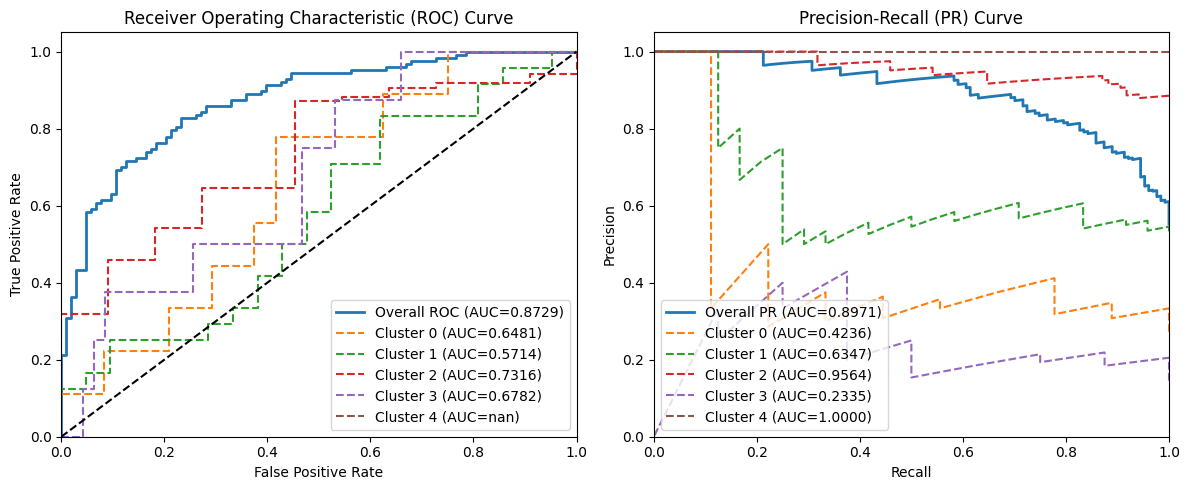

{0: {'f1-score': 0.2857142857142857,
  'roc_auc': 0.6481481481481481,
  'pr_auc': 0.4235917073832674},
 1: {'f1-score': 0.6545454545454545,
  'roc_auc': 0.5714285714285714,
  'pr_auc': 0.6347352292595821},
 2: {'f1-score': 0.9392265193370166,
  'roc_auc': 0.7315508021390374,
  'pr_auc': 0.9564306859881544},
 3: {'f1-score': 0.0,
  'roc_auc': 0.6781914893617021,
  'pr_auc': 0.2334610907675689},
 4: {'f1-score': 1.0, 'roc_auc': nan, 'pr_auc': 1.0}}

In [30]:
evaluate_classification(pred_label, test_data[2].iloc[:,1], clusters=clusters)


              precision    recall  f1-score   support

         0.0       0.78      0.74      0.76       103
         1.0       0.80      0.83      0.82       127

    accuracy                           0.79       230
   macro avg       0.79      0.79      0.79       230
weighted avg       0.79      0.79      0.79       230

ROC AUC: 0.8729
PR AUC: 0.8971

Per-Cluster Metrics:
              precision    recall  f1-score   support

         0.0       0.75      0.88      0.81        24
         1.0       0.40      0.22      0.29         9

    accuracy                           0.70        33
   macro avg       0.57      0.55      0.55        33
weighted avg       0.65      0.70      0.67        33

            ROC AUC=0.6481, PR AUC=0.4236
              precision    recall  f1-score   support

         0.0       0.57      0.38      0.46        21
         1.0       0.58      0.75      0.65        24

    accuracy                           0.58        45
   macro avg       0.58      0.57

c:\Users\Elissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Elissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Elissa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

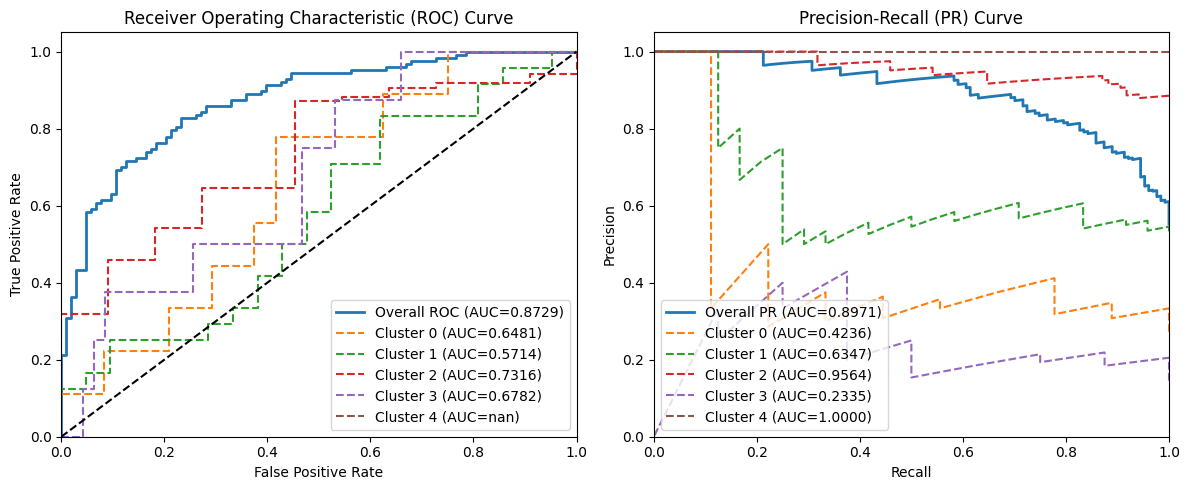

{0: {'f1-score': 0.2857142857142857,
  'roc_auc': 0.6481481481481481,
  'pr_auc': 0.4235917073832674},
 1: {'f1-score': 0.6545454545454545,
  'roc_auc': 0.5714285714285714,
  'pr_auc': 0.6347352292595821},
 2: {'f1-score': 0.9392265193370166,
  'roc_auc': 0.7315508021390374,
  'pr_auc': 0.9564306859881544},
 3: {'f1-score': 0.0,
  'roc_auc': 0.6781914893617021,
  'pr_auc': 0.2334610907675689},
 4: {'f1-score': 1.0, 'roc_auc': nan, 'pr_auc': 1.0}}

In [31]:
evaluate_classification(pred_label, test_data[2].iloc[:,1], clusters=clusters)

In [32]:
# evaluate_classification(1-pred_label, test_data[2].iloc[:,0], clusters=clusters)